In [1]:
import sys
from pathlib import Path

import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('../lib')
from local_paths import analysis_dir, mplstyle_path
from stats_utils import get_bootstrap_spread
from summary_utils import verified_update, annotate_unit_df, select_units, summarize_results_per_region, region_palette

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
analysis_name = 'trial_level_psth'
results_dir = analysis_dir + analysis_name

# select sessions
dur_sel = 1500  # ms

# unit selection
unit_sel_path = None

# statistics
spread_type = 'ci_of_mean'

# Load data

In [4]:
unit_df = {'Session': [], 'Unit': []}
results = {k: [] for k in ('psth',)}
coords = {}

results_dir = Path(results_dir).expanduser()
for fp in results_dir.glob('*.h5'):
    with h5.File(fp, 'r') as f:
        try:
            assert f[f'progress_report/{analysis_name}/all_done'][()]
            dur = f[analysis_name+'/mode_dur'][()]
            dset = f[analysis_name+'/mean_responses']
        except (KeyError, AssertionError):
            continue

        if dur != dur_sel: continue

        unit_names = dset.attrs['unit'][()].astype(str)
        ts = dset.attrs['time']
        verified_update(coords, dict(time=ts, dur=dur))
        results['psth'].append(dset[()])

    unit_df['Session'].append(np.full(unit_names.size, fp.stem))
    unit_df['Unit'].append(unit_names)

print('coordinates:')
for k, v in coords.items():
    print('\t', k, v.shape, v.dtype)
print('results:')
for d in (results, unit_df):
    for k, v in d.items():
        d[k] = v = np.concatenate(v, axis=-1)
        print('', f'{k:<15s}', v.shape, v.dtype, sep='\t')
print(np.unique(unit_df['Session']).size, 'sessions')
unit_df = annotate_unit_df(pd.DataFrame(unit_df))

coordinates:
	 time (50,) int64
	 dur () int64
results:
	psth           	(50, 45329)	float32
	Session        	(45329,)	<U10
	Unit           	(45329,)	<U4
418 sessions


# Select units

In [5]:
result_vals = results['psth']
del results

In [6]:
unit_df, unit_sel, regions = select_units(
    unit_df,
    selection_path=unit_sel_path,
    select_valid_values=result_vals)
result_vals = result_vals[...,unit_sel]

> Selected units: n = 45253 of 45329 (99.8%) with valid values
> No rare subject to exclude
	 min norm. units per region: Region
	AIT    0.155568
	CIT    0.147844
	PIT    1.000000
	V1     0.991843
	V2     1.000000
	V4     0.816844
	Name: Norm. units, dtype: float64


In [7]:
unit_df.reset_index()[['Session','Unit']].to_csv('unit_sel/fig1g.csv.gz', index=False)

# Normalize PSTHs

In [8]:
n = np.percentile(result_vals, 95, axis=0)
n[n==0] = 1
norm_psths = result_vals / n

# Summarize results per region

In [9]:
summary = summarize_results_per_region(
    unit_df=unit_df,
    result_vals=norm_psths[None,:,:],
    spread_type=spread_type)

center/spread estimate: ci_of_mean


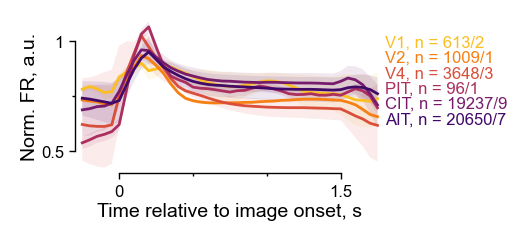

In [10]:
fig = plt.figure(figsize=(2,1))
ax = plt.gca()
ts = coords['time'] / 1e3
tm = (ts >= -.25) & (ts <= 1.75)
icond = 0

for region in regions:
    color = region_palette[region]
    m, bs = summary['one-level_center_boots'][region]
    ax.plot(ts[tm], m[icond,tm], color=color)
    spread = get_bootstrap_spread(m[icond,tm], bs[:,icond,tm], spread_type)
    ax.fill_between(ts[tm], *spread, ec='none', fc=color, alpha=0.1)

ax.set_xlim(-.3, 1.8)
ax.set_xticks([0, 1.5])
ax.set_xticks([.5, 1], minor=True)
ax.set_xticklabels(['0', '1.5'])
ax.spines['bottom'].set_bounds([0, 1.5])
ax.set_xlabel('Time relative to image onset, s')

ax.set_ylim(.4, 1.1)
ax.set_yticks([0.5, 1])
ax.set_yticks([.75], minor=True)
ax.set_yticklabels(['0.5', '1'])
ax.spines['left'].set_bounds([.5, 1])
ax.set_ylabel('Norm. FR, a.u.')

h = .9
for region in regions:
    c = region_palette[region]
    ns = summary['two-level_nunit'][region].values()
    ns = np.array(list(ns))
    l = f'{region}, n = {ns.sum()}/{len(ns)}'
    ax.text(1, h, l, ha='left', va='top',
            transform=ax.transAxes, color=c, fontsize=6)
    h -= .1

print('center/spread estimate:', spread_type)

fig.savefig('plots/fig1g.png')